In [2]:
import numpy as np
from smt.applications import EGO
from smt.surrogate_models import KRG
from smt.utils.design_space import DesignSpace
import matplotlib.pyplot as plt

3


Minimum in x=18.9 with f(x)=-15.1
how many sampling data ? 3
how many sampling data ? 4
how many sampling data ? 5
how many sampling data ? 6
how many sampling data ? 7
how many sampling data ? 8


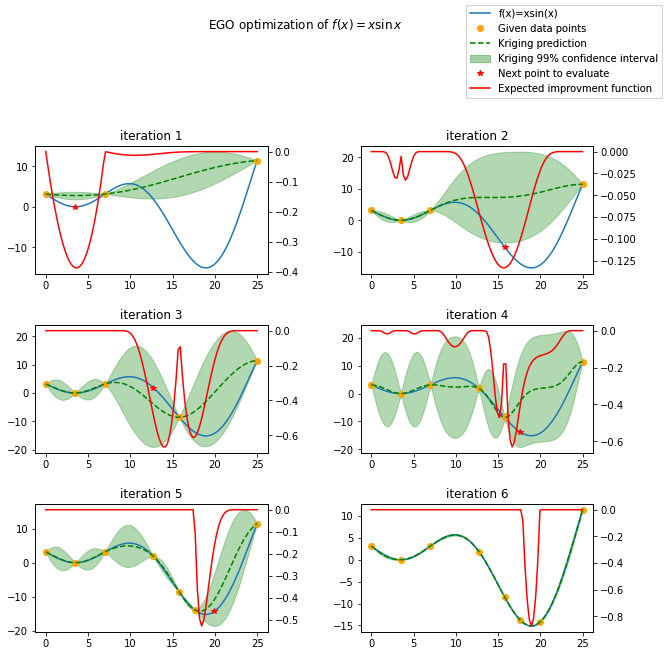

In [1]:
import numpy as np
from smt.applications import EGO
from smt.surrogate_models import KRG
from smt.utils.design_space import DesignSpace
import matplotlib.pyplot as plt

def function_test_1d(x):
    # function xsinx
    import numpy as np

    x = np.reshape(x, (-1,))
    y = np.zeros(x.shape)
    y = (x - 3.5) * np.sin((x - 3.5) / (np.pi))
    return y.reshape((-1, 1))

n_iter = 6
xlimits = np.array([[0.0, 25.0]])
design_space = DesignSpace(xlimits)
xdoe = np.atleast_2d([0, 7, 25]).T
n_doe = xdoe.size

print(n_doe)
criterion = "LCB"  #'EI' or 'SBO' or 'LCB'

# use EI to create ego, xdoe is for initializing the EGO function.
ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=KRG(design_space=design_space, print_global=False),
)

x_opt, y_opt, _, x_data, y_data = ego.optimize(fun=function_test_1d)

print("Minimum in x={:.1f} with f(x)={:.1f}".format(float(x_opt), float(y_opt)))

x_plot = np.atleast_2d(np.linspace(0, 25, 100)).T
y_plot = function_test_1d(x_plot)

fig = plt.figure(figsize=[10, 10])
for i in range(n_iter):
    k = n_doe + i
    x_data_k = x_data[0:k]
    y_data_k = y_data[0:k]

    # Through current sampling data points, we approxiamte the current GP model.
    ego.gpr.set_training_values(x_data_k, y_data_k)
    ego.gpr.train()
    
    # Then we use the GP model to predict values based on current x values.
    y_gp_plot = ego.gpr.predict_values(x_plot)
    y_gp_plot_var = ego.gpr.predict_variances(x_plot)

    
    y_ei_plot = -ego.EI(x_plot)

    ax = fig.add_subplot((n_iter + 1) // 2, 2, i + 1)
    ax1 = ax.twinx()
    (ei,) = ax1.plot(x_plot, y_ei_plot, color="red")

    (true_fun,) = ax.plot(x_plot, y_plot)
    (data,) = ax.plot(
        x_data_k, y_data_k, linestyle="", marker="o", color="orange"
    )
    if i < n_iter - 1:
        (opt,) = ax.plot(
            x_data[k], y_data[k], linestyle="", marker="*", color="r"
        )
    (gp,) = ax.plot(x_plot, y_gp_plot, linestyle="--", color="g")
    sig_plus = y_gp_plot + 3 * np.sqrt(y_gp_plot_var)
    sig_moins = y_gp_plot - 3 * np.sqrt(y_gp_plot_var)
    un_gp = ax.fill_between(
        x_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
    )
    lines = [true_fun, data, gp, un_gp, opt, ei]
    fig.suptitle("EGO optimization of $f(x) = x \sin{x}$")
    fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
    ax.set_title("iteration {}".format(i + 1))
    fig.legend(
        lines,
        [
            "f(x)=xsin(x)",
            "Given data points",
            "Kriging prediction",
            "Kriging 99% confidence interval",
            "Next point to evaluate",
            "Expected improvment function",
        ],
    )
plt.show()

